# Dimensionality reduction and clustering

In this step of the pipeline, we are employing dimensionality reduction techniques such as PCA and UMAP to look at interesting data points in the set, and then run clustering with Louvain's method.

In [1]:
import numpy as np
import pandas
import scanpy
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import scanpy as sc

import os

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

BATCH_LABELS = ("S1", "S2")

/home/ubuntu/.local/lib/python3.6/site-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


scanpy==1.4 anndata==0.6.19 numpy==1.16.2 scipy==1.2.1 pandas==0.24.2 scikit-learn==0.20.3 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


## Load previous data
We will now load the data saved in the previous step.

In [2]:
batches = {}

for batch in BATCH_LABELS:
    filename = "tgfb1-3-" + batch + ".h5ad"
    filename = os.path.join("write", filename)
    batches[batch] = anndata.read(filename)

batches

{'S1': AnnData object with n_obs × n_vars = 5024 × 2466 
     obs: 'batch', 'cellular_barcode', 'n_counts', 'n_genes', 'percent_mito', 'S_score', 'G2M_score', 'phase'
     var: 'gene_names', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'genes_before_highly_variable', 'genes_original', 'pca', 'phase_colors'
     obsm: 'X_pca'
     varm: 'PCs'
     layers: 'ambiguous', 'spliced', 'unspliced',
 'S2': AnnData object with n_obs × n_vars = 7048 × 2027 
     obs: 'batch', 'cellular_barcode', 'n_counts', 'n_genes', 'percent_mito', 'S_score', 'G2M_score', 'phase'
     var: 'gene_names', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'genes_before_highly_variable', 'genes_original', 'pca', 'phase_colors'
     obsm: 'X_pca'
     varm: 'PCs'
     layers: 'ambiguous', 'spliced', 'unspliced'}

## Confirm PCA tool data was saved
We will re-generate the old PCA plots for each batch as a confirmation that the data has been saved.

PCA plot for batch S1


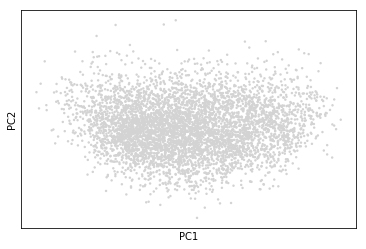

PCA plot for batch S2


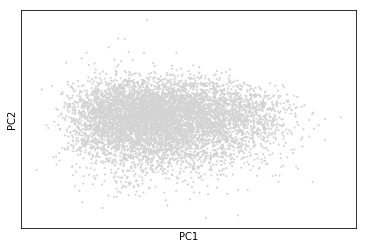

In [3]:
for batch, matrix in batches.items():
    print("PCA plot for batch", batch)
    sc.pl.pca(matrix)

## TGFB1-values in cells

We will check if TGFB1 is present in each of the batches. Then, we make a PCA-plot visualizing TGFB1-counts in the different batches.

TGFB1 present in batch S1 :  False
TGFB1 present in batch S2 :  True
Printing TGFB1 PCA plot for batch S2


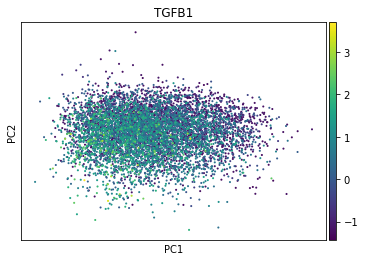

In [4]:
for batch, matrix in batches.items():
    present = any(matrix.var.gene_names == "TGFB1")
    print("TGFB1 present in batch", batch, ": ", present)
    
    if present:
        print("Printing TGFB1 PCA plot for batch", batch)
        sc.pl.pca(matrix, color="TGFB1")

Let's generate a variance ratio plot for each batch. This is useful because it provides insight into how much each PC contributes to the variance of the set. We can use this information as a cut-off for neighborhood graph calculations.

Printing PCA variance ratio for batch S1


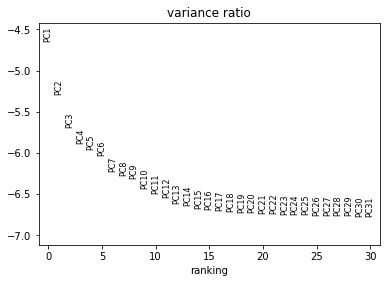

Printing PCA variance ratio for batch S2


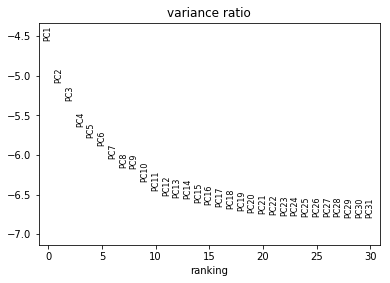

In [5]:
for batch, matrix in batches.items():
    print("Printing PCA variance ratio for batch", batch)
    sc.pl.pca_variance_ratio(matrix, log=True)

## Computing the neighborhood graph

We are computing the neighborhood graph on the cells per each batch, using the previously established principal components.

TODO: For the sake of reproducing Seurat's results, let's take the following values. more descriptive reason?

In [6]:
for batch, matrix in batches.items():
    print("Neighborhood graph calculation for batch", batch)
    sc.pp.neighbors(matrix, n_neighbors=10, n_pcs=40)

Neighborhood graph calculation for batch S1
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:04.74) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
Neighborhood graph calculation for batch S2
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:01.75) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


## UMAP

We can use UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)) to get a two-dimensional representation of the neighborhood graph. This method is preferred over tSNE because (per the abstract) "\[it\] is competitive with t-SNE for visualization quality, and arguably preserves more of the global structure with superior run time performance."


In [7]:
for batch, matrix in batches.items():
    print("UMAP calculations for batch", batch)
    sc.tl.umap(matrix)

UMAP calculations for batch S1
computing UMAP
    finished (0:00:13.50) --> added
    'X_umap', UMAP coordinates (adata.obsm)
UMAP calculations for batch S2
computing UMAP
    finished (0:00:16.94) --> added
    'X_umap', UMAP coordinates (adata.obsm)


Create a list of marker genes that we want analyze more deeply:

In [8]:
MARKER_GENES = ("TGFB1", "TGFBR1", "TGFBR2", "SERPINE1", "ID3", "PLAUR", "ACTA2", "ACVRL1")

Create UMAP plots for each batch for all the marker genes found in that data set.

Finding marker genes in S1
Found the following marker genes: ['TGFBR2'] , printing UMAP plots for these genes.


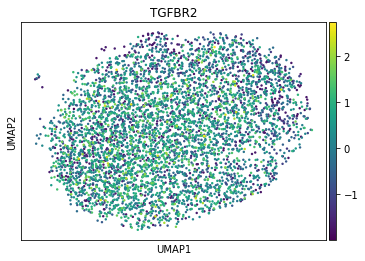

Finding marker genes in S2
Found the following marker genes: ['TGFB1', 'SERPINE1', 'ID3', 'PLAUR', 'ACTA2'] , printing UMAP plots for these genes.


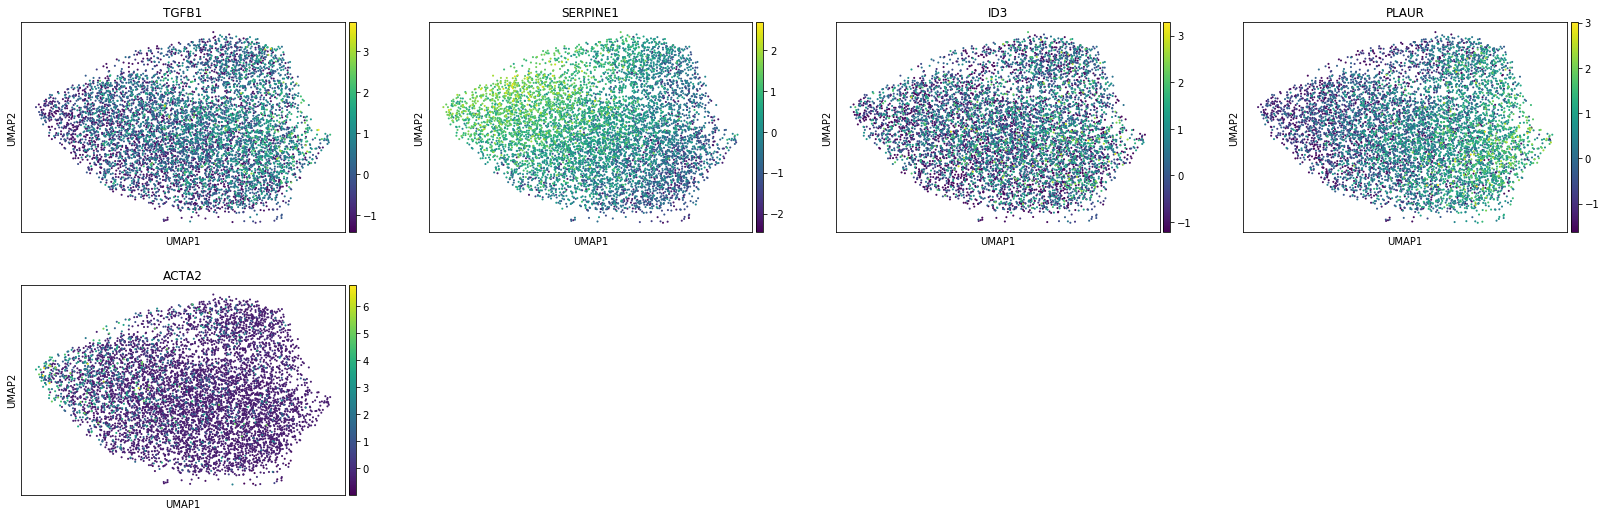

In [9]:
for batch, matrix in batches.items():
    print("Finding marker genes in", batch)
    filter_by = [var for var in MARKER_GENES if var in matrix.var_names]
    print("Found the following marker genes:", filter_by, ", printing UMAP plots for these genes.")
    sc.pl.umap(matrix, color=filter_by)

## Clustering the neighborhood graph

The Louvain clustering method is an effective way to find communities in large networks (such as the neighborhood graph previously computed) through modularity optimizations. The original paper is [Blondel et al. (2008)](https://doi.org/10.1088/1742-5468/2008/10/P10008) and it has been proposed for single-cell analysis by [Levine et al. (2015)](https://doi.org/10.1016/j.cell.2015.05.047).

In [11]:
for batch, matrix in batches.items():
    print("Running Louvain clustering on", batch)
    sc.tl.louvain(matrix)

Running Louvain clustering on S1
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.42) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Running Louvain clustering on S2
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.58) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


We are expecting some of these clusters to highly correlate with the marker genes we named earlier for the S2 (treated) batch.

Plotting UMAP plot for Louvain clusters, as well as previous marker genes.
Found the following marker genes in batch S1 : ['TGFBR2']
Printing UMAP plots comparing Louvain clusters to marker genes in batch S1


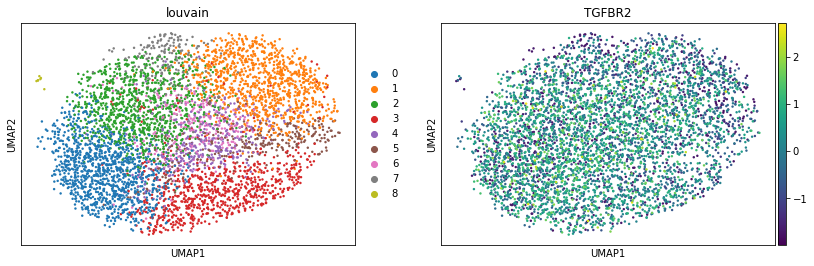

Plotting UMAP plot for Louvain clusters, as well as previous marker genes.
Found the following marker genes in batch S2 : ['TGFB1', 'SERPINE1', 'ID3', 'PLAUR', 'ACTA2']
Printing UMAP plots comparing Louvain clusters to marker genes in batch S2


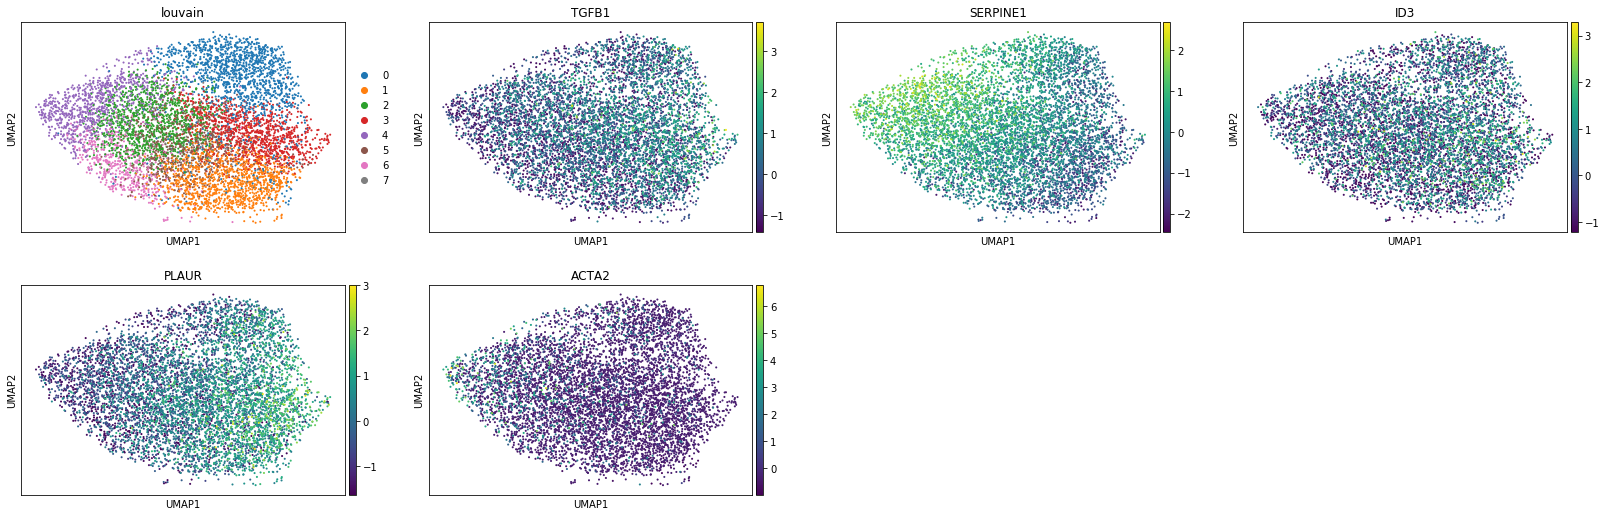

In [12]:
for batch, matrix in batches.items():
    print("Plotting UMAP plot for Louvain clusters, as well as previous marker genes.")
    filter_by = [var for var in MARKER_GENES if var in matrix.var_names]
    print("Found the following marker genes in batch", batch, ":", filter_by)
    filter_by.insert(0, "louvain")
    print("Printing UMAP plots comparing Louvain clusters to marker genes in batch", batch)
    sc.pl.umap(matrix, color=filter_by)

Save the result, then compute signatures

In [18]:
SIGNATURES = {"cVSMC signature" : ["ACTA2", "TAGLN", "CNN1", "TAGLN2", "MYOCDN", "SMTN",]}

Now working on batch S1


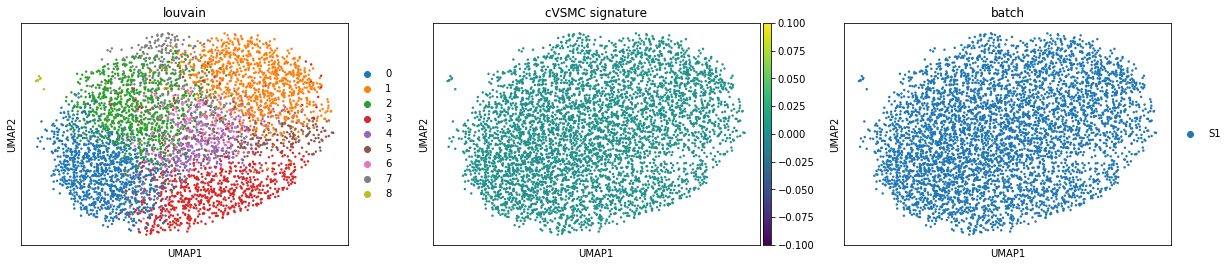

Now working on batch S2


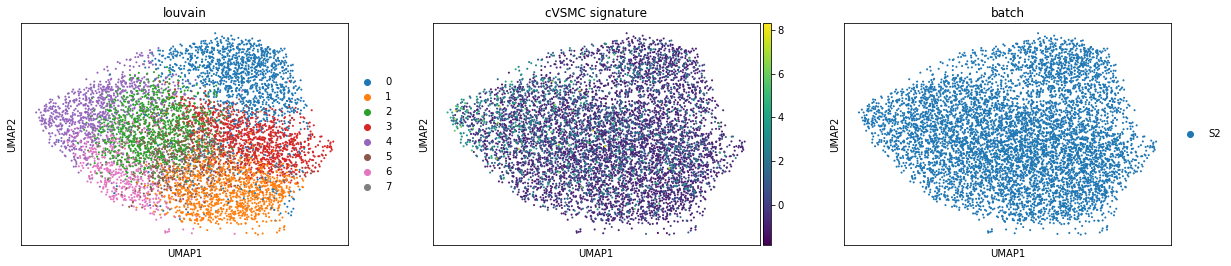

In [21]:
for batch, matrix in batches.items():
    print("Now working on batch", batch)
    for key, value in SIGNATURES.items():
        matrix.obs[key] = matrix[:, matrix.var.gene_names.isin(value)].X.sum(1)
        sc.pl.umap(matrix, color=['louvain', 'cVSMC signature', 'batch'])

Compute violin plots for signatures as above

Now working on batch S1


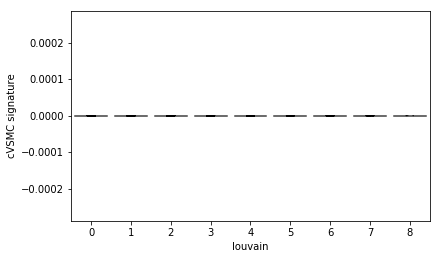

Now working on batch S2


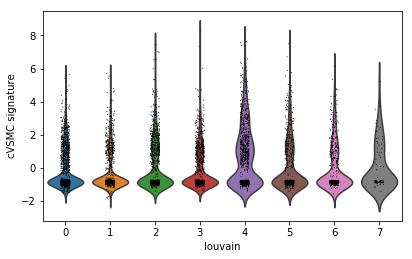

In [22]:
for batch, matrix in batches.items():
    print("Now working on batch", batch)
    for key, value in SIGNATURES.items():
        sc.pl.violin(matrix, [key], groupby='louvain')

In [ ]:
sc.pl.violin(batch_2, ['ALK1 signature'], groupby='louvain')

In [ ]:
sc.pl.violin(batch_2, ['cVSMC signature'], groupby='louvain')

Now working on batch S1
no jarid2


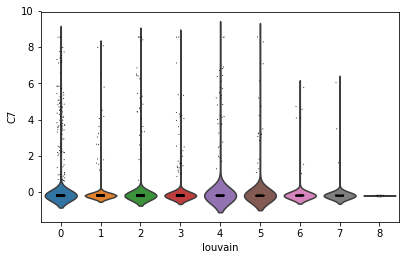

Now working on batch S2


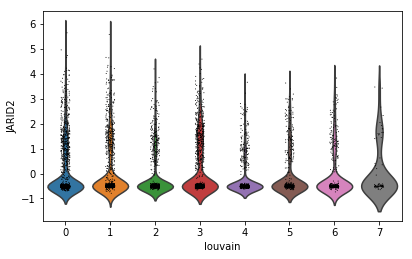

no c7


In [25]:
for batch, matrix in batches.items():
    print("Now working on batch", batch)
    try:
        sc.pl.violin(matrix, ['JARID2'], groupby='louvain')
    except:
        print("no jarid2")
    
    try:
        sc.pl.violin(matrix, ['C7'], groupby='louvain')
    except:
        print("no c7")

In [ ]:
for batch, matrix in batches.items():
    filename = "tgfb1-4-" + batch + ".h5ad"
    filename = os.path.join("write", filename)
    matrix.write(filename)